## Условие задачи

Необходимо постоить модель предсказания итоговой температуры стали в каждой партии с целью оптимизации технологиечского процесса.

### Укрупненный технологический процесс:
- расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами
- Из сплава выводится сера (десульфурация)
- добавлением примесей корректируется химический состав и отбираются пробы
- Перед тем как первый раз ввести легирующие добавки, **измеряют температуру стали** и производят её химический анализ
    - температуру на несколько минут повышают
    - сталь легируют, подавая сыпучие материалы или проволоку
    - продувают сплав инертным газом
    - перемешивают и **снова проводят измерения**
- цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки
- расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

## 1. Загрузка и анализ данных

In [2]:
df_arc = pd.read_csv('arc.csv')
df_bulk = pd.read_csv('bulk.csv')
df_bulk_time = pd.read_csv('bulk_time.csv')
df_gas = pd.read_csv('gas.csv')
df_temp = pd.read_csv('data_temp.csv')
df_wire = pd.read_csv('data_wire.csv')
df_wire_time = pd.read_csv('data_wire_time.csv')

### 1.1 Данные о нагреве электродами

In [3]:
print(df_arc.shape)
df_arc.info()
df_arc.head(5)

(14876, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


Пропусков нет, взглянем на распределение:

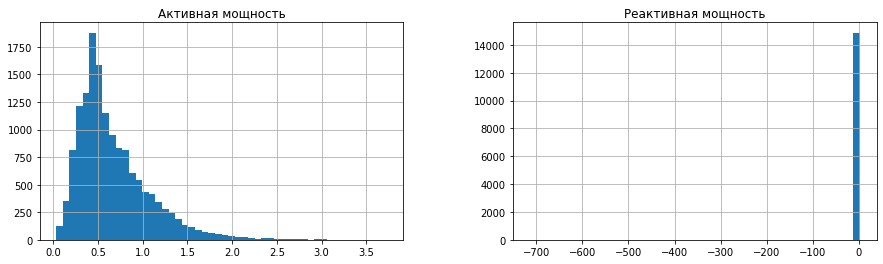

In [4]:
df_arc[['Активная мощность', 'Реактивная мощность']].hist(bins=50, figsize=(15,4))
plt.show()

#### Данные РЕАКТИВНОЙ мощности "собрались" в один столбец, видимо, есть сильные выбросы

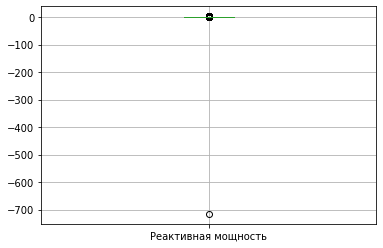

In [5]:
df_arc.boxplot('Реактивная мощность')
plt.show()

Так и есть

In [6]:
df_arc['Реактивная мощность'].describe()

count    14876.000000
mean         0.452592
std          5.878702
min       -715.504924
25%          0.290991
50%          0.415962
75%          0.637371
max          2.676388
Name: Реактивная мощность, dtype: float64

In [7]:
df_arc['Реактивная мощность'].value_counts().sort_index()

-715.504924    1
 0.020806      1
 0.021154      1
 0.022485      1
 0.022983      1
              ..
 2.335088      1
 2.397032      1
 2.459959      1
 2.504206      1
 2.676388      1
Name: Реактивная мощность, Length: 14866, dtype: int64

Сверх экстремальным выглядит только это значение

#### Оценим ситуацию с активной мощностью

In [8]:
df_arc['Активная мощность'].describe()

count    14876.000000
mean         0.670441
std          0.408159
min          0.030002
25%          0.395297
50%          0.555517
75%          0.857034
max          3.731596
Name: Активная мощность, dtype: float64

In [9]:
df_arc['Активная мощность'].value_counts().sort_index()

0.030002    1
0.030188    1
0.030190    1
0.030563    1
0.031630    1
           ..
3.052813    1
3.107820    1
3.150762    1
3.156276    1
3.731596    1
Name: Активная мощность, Length: 14869, dtype: int64

- #### у РЕАКТИВНОЙ мощности картину искажает значение -715,
- #### макс. значение РЕАКТ и значения АКТ мощности не выглядят экстремальнымм, удалять/заменять их не будем (м б это не выбросы, а просто технологи пробовали разные варианты нагрева, либо какая-то редкая особенность техпроцесса)

Избавимся от отрицательной мощности:

In [10]:
df_arc = df_arc[df_arc['Реактивная мощность'] > 0]

#### Кроме того, Реактивная мощность не должна быть выше активной. Значит эти данные тоже могу являться выбросами

Посчитаем, сколько таких случаев:

In [11]:
len(df_arc[df_arc['Реактивная мощность'] > df_arc['Активная мощность']])

416

In [12]:
print('"Правильные" данные')
print('Средняя активная ', end="")
print(df_arc[df_arc['Реактивная мощность'] < df_arc['Активная мощность']]['Активная мощность'].mean().round(2))
print('Средняя реактивная ', end="")
print(df_arc[df_arc['Реактивная мощность'] < df_arc['Активная мощность']]['Реактивная мощность'].mean().round(2))
print()

print('"НЕправильные" данные')
print('Средняя активная ', end="")
print(df_arc[df_arc['Реактивная мощность'] > df_arc['Активная мощность']]['Активная мощность'].mean().round(2))
print('Средняя реактивная ', end="")
print(df_arc[df_arc['Реактивная мощность'] > df_arc['Активная мощность']]['Реактивная мощность'].mean().round(2))
print()

print('Соотношение активной и реактивной мощности:')
print('- в правильных данных ', (df_arc[df_arc['Реактивная мощность'] < df_arc['Активная мощность']]['Активная мощность']/
df_arc[df_arc['Реактивная мощность'] < df_arc['Активная мощность']]['Реактивная мощность']).mean().round(2))
print('- в НЕправильных данных ', (df_arc[df_arc['Реактивная мощность'] > df_arc['Активная мощность']]['Активная мощность']/
df_arc[df_arc['Реактивная мощность'] > df_arc['Активная мощность']]['Реактивная мощность']).mean().round(2))

"Правильные" данные
Средняя активная 0.67
Средняя реактивная 0.49

"НЕправильные" данные
Средняя активная 0.59
Средняя реактивная 0.7

Соотношение активной и реактивной мощности:
- в правильных данных  1.38
- в НЕправильных данных  0.85


#### Возможные варианты действий:
1. Удалить данные
2. Сделать реактивную в 1,38 раза меньше активной
3. Поменять их местами, если замеры могли перепутать (большого смысла не имеет, так как я использую суммарную мощность как признак)

Попробовал все варианты, 2 и 3 показывают примерно одинаковые варианты, и, так как в общий датасет идет суммарная мощность итерации, оставил данные в исходном виде

#### Выделение признаков в данных нагрева
- посчитаем суммарное время нагрева за один key в секундах
- Посчитаем полную мощность каждой итерации по формуле $S=\sqrt{P^2 + Q^2}$ и сгруппируем с выводом средней и подсчетом количества итераций

In [13]:
df_arc['Суммарн мощность'] = (df_arc['Активная мощность']**2 + df_arc['Реактивная мощность']**2)**0.5
df_arc['Время нагрева'] = pd.to_datetime(df_arc['Конец нагрева дугой']) - pd.to_datetime(df_arc['Начало нагрева дугой'])
df_arc['Время нагрева'] = df_arc['Время нагрева'].dt.total_seconds()
df_arc2 = df_arc.groupby('key').agg({'Время нагрева':'sum', 'Суммарн мощность':['mean','count']})
df_arc2

Время нагрева Суммарн мощность      
               sum             mean count
key                                      
1           1098.0         1.165279     5
2            811.0         0.912304     4
3            655.0         0.597907     5
4            741.0         0.953741     4
5            869.0         1.008939     4
...            ...              ...   ...
3237         909.0         0.968996     5
3238         546.0         0.898847     3
3239        1216.0         0.701485     8
3240         839.0         0.778371     5
3241         659.0         0.599903     5

[3214 rows x 3 columns]

### 1.2 Данные о подаче сыпучих материалов

In [14]:
print(df_bulk.shape)
df_bulk.info()
df_bulk.head()

(3129, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


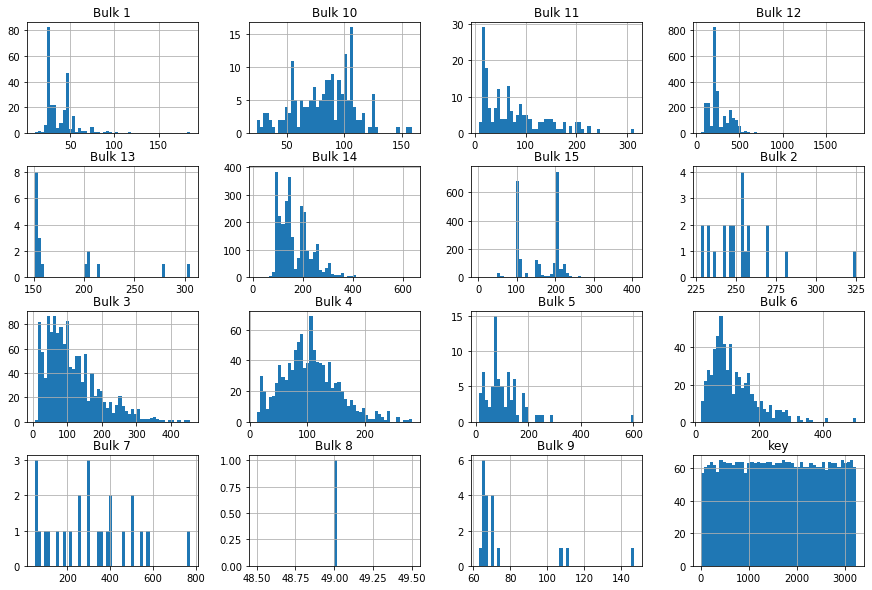

In [15]:
df_bulk.hist(bins=50, figsize=(15,10))
plt.show()

In [16]:
df_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


- По "Bulk 8" - всего одно значение, что и отображается на гистограмме
- В целом, значения хоть и имеют некоторые выбросы, но выглядят адеватными, так как мы не знамем природу данных и особенности ТП, обрабатывать их не будем

### 1.3 Данные о проволочных материалах

In [17]:
print(df_wire.shape)
df_wire.info()
df_wire.head()

(3081, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


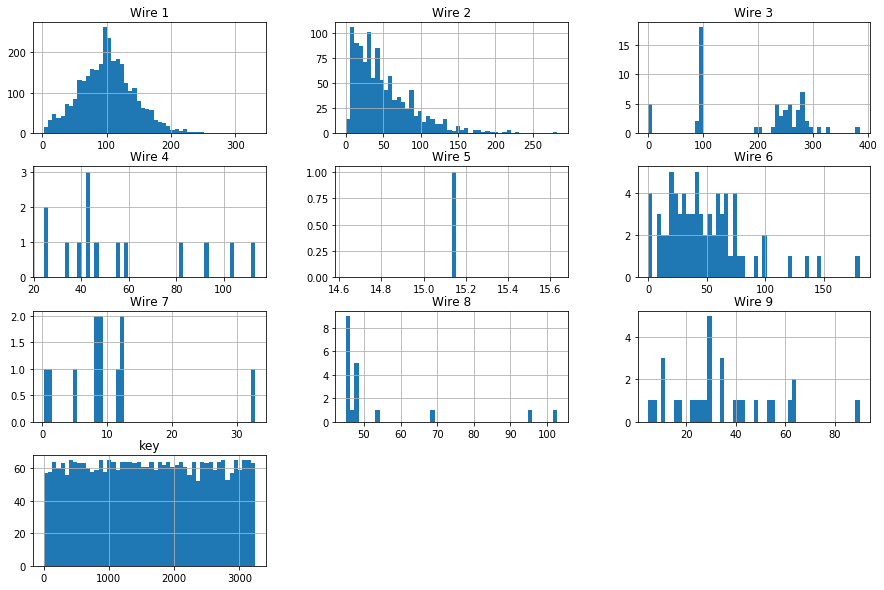

In [18]:
df_wire.hist(bins=50, figsize=(15,10))
plt.show()

In [19]:
print(df_wire_time.shape)
df_wire_time.info()
df_wire_time.head()

(3081, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### В части обработки выбросов - аналогично данным по сыпучим материалам

### 1.4 Данные о продувке инертным газом

In [20]:
print(df_gas.shape)
df_gas.info()
df_gas.head(5)

(3239, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


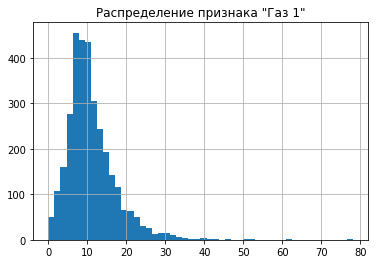

In [21]:
df_gas['Газ 1'].hist(bins=50).set_title('Распределение признака "Газ 1"')
plt.show()

### 1.5 Данные о температуре

In [22]:
print(df_temp.shape)
df_temp.info()

(15907, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [23]:
df_temp['Температура'].describe()

count    13006.000000
mean      1591.840920
std         21.375851
min       1191.000000
25%       1581.000000
50%       1591.000000
75%       1601.000000
max       1705.000000
Name: Температура, dtype: float64

In [24]:
df_temp

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


#### Есть пропуски в показаниях температуры

In [25]:
df_temp[pd.isnull(df_temp['Температура'])].index

Int64Index([12268, 12269, 12270, 12272, 12273, 12274, 12275, 12277, 12278,
            12279,
            ...
            15896, 15897, 15898, 15899, 15900, 15901, 15903, 15904, 15905,
            15906],
           dtype='int64', length=2901)

Из которых большое количество пропусков **в последних записях температуры**.

При выделения признаков из данных замеров мы учтем эту особенность

#### Взглянем на распределение

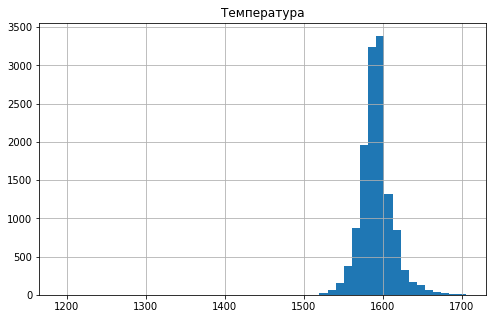

In [26]:
df_temp.hist('Температура', bins=50, figsize=(8,5))
plt.show()

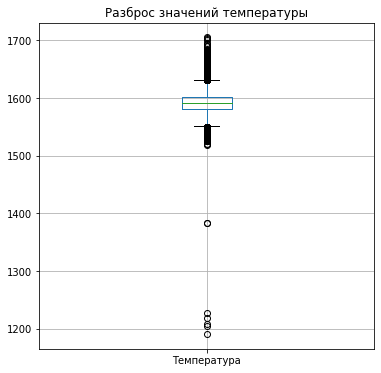

In [27]:
df_temp.boxplot('Температура', figsize=(6,6)).set_title('Разброс значений температуры')
plt.show()

Есть сильные выбросы в небольшом количестве, рассмотрим их:

In [28]:
low_temp = df_temp[df_temp['Температура'] < 1400]
low_temp

,key,Время замера,Температура
4350,867,2019-06-04 14:21:00,1191.0
5978,1214,2019-06-16 05:32:00,1208.0
7958,1619,2019-06-30 11:03:54,1218.0
8913,1818,2019-07-07 00:30:49,1383.0
8914,1818,2019-07-07 00:31:40,1383.0
10127,2052,2019-07-21 14:51:40,1227.0
12564,2561,2019-08-08 07:34:15,1204.0


Взглянем на остальные замеры в этих партиях:

In [29]:
df_temp.query('key in @low_temp.key')

,key,Время замера,Температура
4350,867,2019-06-04 14:21:00,1191.0
4351,867,2019-06-04 14:29:35,1575.0
4352,867,2019-06-04 14:30:29,1576.0
4353,867,2019-06-04 14:43:10,1571.0
4354,867,2019-06-04 14:52:54,1600.0
4355,867,2019-06-04 14:57:17,1599.0
5978,1214,2019-06-16 05:32:00,1208.0
5979,1214,2019-06-16 05:49:01,1608.0
5980,1214,2019-06-16 05:51:28,1608.0
5981,1214,2019-06-16 05:51:38,1608.0


**Слишком резкие перепады в температурах**, если посмотреть на операции нагрева в эти же периоды и добавления материалов не должны были привести к таким показателям, например:
- цикл 1818
    - в 00:27:23	температура 1663.0
    - нагрев с 00:27:36	до 00:30:07 (см. ниже)
    - и в 00:30:49	температура  становится 1383.0 (другие материалы не подавались и операции не проводились)

In [30]:
df_arc.query('key == 1818')

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Суммарн мощность,Время нагрева
8356,1818,2019-07-06 23:56:28,2019-07-06 23:59:37,0.651823,0.502454,0.823003,189.0
8357,1818,2019-07-07 00:01:20,2019-07-07 00:11:25,2.578762,1.864259,3.182055,605.0
8358,1818,2019-07-07 00:13:13,2019-07-07 00:20:29,1.850526,1.355337,2.293771,436.0
8359,1818,2019-07-07 00:27:36,2019-07-07 00:30:07,0.682983,0.499500,0.846148,151.0
8360,1818,2019-07-07 00:37:16,2019-07-07 00:38:27,0.317887,0.237541,0.396835,71.0


**Поэтому можно усечь данные по температуре меньше 1400 С (усекать "уже" не будем)**

### Выделение признаков из замеров температуры
- сначала заполним пропуски в столбце замеров на 0 (чтобы потом вычленить и удалить последние температуры с пропусками)
- затем сгруппируем по key и выделим первую и последнюю температуры

In [31]:
df_temp2 = df_temp.query('key not in @low_temp.key').fillna(0).drop('Время замера', axis=1).groupby('key').agg(['first', 'last'])
df_temp2 = df_temp2[df_temp2['Температура', 'last']>0] # и оставим данные без нулей в последней температуре

In [32]:
df_temp2

Температура        
           first    last
key                     
1         1571.0  1613.0
2         1581.0  1602.0
3         1596.0  1599.0
4         1601.0  1625.0
5         1576.0  1602.0
...          ...     ...
2495      1570.0  1591.0
2496      1554.0  1591.0
2497      1571.0  1589.0
2498      1591.0  1594.0
2499      1569.0  1603.0

[2472 rows x 2 columns]

1. **Мы осуществили загрузку, анализ и предобработку данных, в том числе:**
    - удалили неадекватное значение в показателях мощности нагрева
    - удалили данные с сильными выбросами по температуре
    - удалили данные с пропусками в последнем замере температуры
    

2. **Выделили признаки из данных:**
    - суммарное время нагрева каждой партии
    - средняя суммарная (активная+реактивная) мощность нагрева каждой партии
    - количество процессов нагрева в партии
    - первый и последний замер температуры каждой партии

#### Пора приступать к объединению данных

## 2. Объединение и подготовка датасетов
Сделаем значения key индексами в каждой таблице и осуществим ним объединение данных

In [33]:
df_wire = df_wire.set_index('key')
df_bulk = df_bulk.set_index('key')
df_gas = df_gas.set_index('key')

In [34]:
df1 = df_arc2.join(df_bulk, on='key', how='outer')
df2 = df1.join(df_wire, on='key', how='outer')
df3 = df2.join(df_gas, on='key', how='outer')
df = df3.join(df_temp2, on='key', how='outer')
df = df.sort_values('key').set_index('key')

/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [35]:
df.columns = ['heating time sum', 'SP mean', 'SP count',
              'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11',
              'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',
              'Wire 7', 'Wire 8', 'Wire 9', 'Gas 1', 'Temp first', 'Temp last']

### Разделим данные на выборки:

In [36]:
df.dropna(subset=['Temp last'], inplace=True)
X = df.drop(['Temp last'], axis=1)
Y = df['Temp last']

X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.25, random_state=123455)

#### Сделаем альтернативные наборы признаков, где пропуски заменим на нули:

In [37]:
X_fillna_train = X_train.fillna(0)
X_fillna_valid = X_valid.fillna(0)

### Масштабирование

In [38]:
# Исходные данные
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)

# Данные с замененными пропусками
scaler = StandardScaler()
scaler.fit(X_fillna_train)
X_fillna_train = scaler.transform(X_fillna_train)
X_fillna_valid = scaler.transform(X_fillna_valid)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/extmath.py:747: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.7/site-packages/sklearn/utils/extmath.py:688: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


## 3. Подбор моделей
Сделаем предсказания на моделях с дефлотными параметрами:
- CatBoost
- LightGBM

На данных с пропусками и без них

In [39]:
def fit_predict(model, X_train, Y_train, X_test):
    model.fit(X_train, Y_train)
    predicted = model.predict(X_test)
    return predicted

def mae(Y_test, predicted):
    return ((mean_squared_error(Y_test, predicted)**0.5)).round(7)

def rmse_gridsearch(score_best):
    return (((score_best)*(-1))**0.5).round(2)

In [41]:
# создадим модели
model_Cat = CatBoostRegressor(random_state=12345)
model_LG = lgb.LGBMRegressor(random_state=12345)

model_Cat_fillna = CatBoostRegressor(random_state=12345)
model_LG_fillna = lgb.LGBMRegressor(random_state=12345)

In [ ]:
pred_Cat = fit_predict(model_Cat, X_train, Y_train, X_valid)
pred_LG = fit_predict(model_LG, X_train, Y_train, X_valid)

In [ ]:
# Данные с замененными пропусками
pred_Cat_fillna = fit_predict(model_Cat_fillna, X_fillna_train, Y_train, X_fillna_valid)
pred_LG_fillna = fit_predict(model_LG_fillna, X_fillna_train, Y_train, X_fillna_valid)

In [44]:
print('--------------"Исходные" данные------------')
print('Cat ', mean_absolute_error(Y_valid, pred_Cat))
print('LGBM', mean_absolute_error(Y_valid, pred_LG))
print('------"Данные с замененными пропусками------')
print('Cat ', mean_absolute_error(Y_valid, pred_Cat_fillna))
print('LGBM', mean_absolute_error(Y_valid, pred_LG_fillna))

--------------"Исходные" данные------------
Cat  5.853535608552306
LGBM 6.092020524663858
------"Данные с замененными пропусками------
Cat  5.894136938648066
LGBM 6.149369949578176


#### Вывод:
Лучшие показатели в обоих случаях у CatBoost, подберем гиперпараметры для этих моделей и для LGBM на данных с пропусками

## 4 Подбор гиперпараметров
#### Зададим функциию подбора гиперпараметров с помощью GridSearch:

In [40]:
def run_gridsearch(model, params, X, Y):
    grid = GridSearchCV(model, params, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
    grid.fit(X, Y)

    print(grid.best_params_)
    print(rmse_gridsearch(grid.best_score_))

In [41]:
parametrs_Cat = {
    'depth': [4, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 4],
    'iterations': [100, 200, 300]
}

parametrs_LGBM = {'max_depth': [20,50,75],
                 'learning_rate': [0.01, 0.05, 0.1],
                 'num_leaves': [300, 900, 1200],
                 'n_estimators': [200, 300]
              }

In [42]:
model_Cat = CatBoostRegressor(random_state=12345)
model_Cat_fillna = CatBoostRegressor(random_state=12345)
model_LGBM = lgb.LGBMRegressor(random_state=12345)

Подбор гиперпараметров осуществлялся одтельно на GPU, приведены итоговые результаты:

In [ ]:
run_gridsearch(model_Cat, parametrs_Cat, X_train, Y_train)

{'depth': 7, 'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.05}

In [ ]:
run_gridsearch(model_Cat_fillna, parametrs_Cat, X_fillna_train, Y_train)

{'depth': 7, 'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.05}

In [ ]:
run_gridsearch(model_LGBM, parametrs_LGBM, X_train, Y_train)

{'learning_rate': 0.05, 'max_depth': 20, 'n_estimators': 200, 'num_leaves': 300}

## 5. Предсказания на тестовых данных
### 5.1  Обучим модели на тестовой выборке с подобранными параметрами:
- CatBoost с параметрами {'depth': 7, 'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.05}
- CatBoost на данных без пропусков {'depth': 7, 'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.05}
- LightGBM с параметрами {'learning_rate': 0.05, 'max_depth': 20, 'n_estimators': 200, 'num_leaves': 300}

#### Зададим функции обучения модели на тренировочных и проверки на тестовых данных с замером времени:

In [43]:
def count_time(model_, X, Y, X_valid, Y_valid):
    start_time = time.perf_counter()
    model = model_
    model.fit(X, Y)
    time_1 = float('{0:.3f}'.format(time.perf_counter() - start_time))
    
    start_time = time.perf_counter()
    predict = model.predict(X_valid)
    MAE = (mean_absolute_error(Y_valid, predict)).round(3)
    time_2 = float('{0:.3f}'.format(time.perf_counter() - start_time))
    print(MAE)
    print(time_1)
    print(time_2)
    return MAE, time_1, time_2

In [45]:
model_Cat_final = CatBoostRegressor(depth=7, learning_rate=0.05, iterations=300, l2_leaf_reg= 1, random_state=12345)
model_Cat_final_fillna = CatBoostRegressor(depth=7, iterations=300, l2_leaf_reg= 1, learning_rate=0.05, random_state=12345)
model_LGBM_final = lgb.LGBMRegressor(learning_rate=0.05, max_depth=20, n_estimators=200, num_leaves=300, random_state=12345)

In [ ]:
MAECat, timeCat1, timeCat2 = count_time(model_Cat_final, X_train, Y_train, X_valid, Y_valid)

- 5.853
- 12.434
- 0.008

In [ ]:
MAECat_fillna, timeCat1_2, timeCat2_2 = count_time(model_Cat_final_fillna, X_fillna_train, Y_train, X_fillna_valid, Y_valid)

- 5.847
- 10.28
- 0.003

In [52]:
MAELGBM, timeLGBM1, timeLGBM2 = count_time(model_LGBM_final, X_train, Y_train, X_valid, Y_valid)

6.146
478.1
0.097


#### Соберем результаты в таблицу и взглянем на важность признаков лучшей модели

In [53]:
data_model = [['CatBoost', MAECat, timeCat1, timeCat2, timeCat1+timeCat2],
              ['CatBoost_fillna', MAECat_fillna, timeCat1_2, timeCat2_2, timeCat1_2+timeCat2_2],
              ['LGBM', MAELGBM, timeLGBM1, timeLGBM2, timeLGBM1+timeLGBM2]]
results = pd.DataFrame(data_model, columns = ['Model', 'MAE','Time_fit','Time_predict', 'Time_total'])

results

,Model,MAE,Time_fit,Time_predict,Time_total
0,CatBoost,5.873,9.725,0.003,9.728
1,CatBoost_fillna,5.894,9.802,0.011,9.813
2,LGBM,6.146,478.100,0.097,478.197


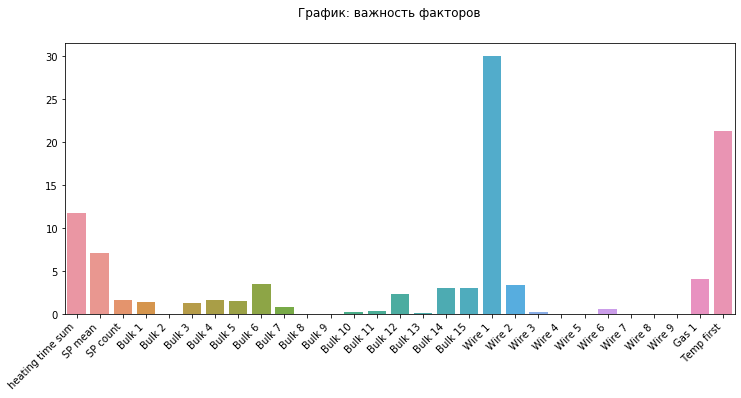

In [48]:
fig, ax = plt.subplots(figsize=(12,5))
fig.suptitle('График: важность факторов')
sns.barplot(y=model_Cat_final.feature_importances_, x=X.columns, ax=ax)
plt.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontweight='light'
)  
plt.show()

#### Лучшая модель - CatBoost с МАЕ=5.873, временем обучения 9,725 и предсказания 0,003

#### Топ-3 важных параметров:
- wire 1 - объем подаваемых проволочных материалов
- Temp first - температура при первом замере
- heating time sum - суммарная время нагрева

### 5.2 Проверка модели на адекватность

Сравним показатели с результатами константой модели. 

Для этого заполним Series медианами тренировочных target:

In [54]:
constant = pd.Series(Y_valid.mean(), index=Y_valid.index)
mean_absolute_error(Y_valid, constant).round(3)

10.628

#### Тоже неплохой результат, но наши модели существенно его опрежают

## Общие выводы
1. **Мы осуществили загрузку, анализ и предобработку данных, в том числе:**
    - удалили неадекватное значение в показателях мощности нагрева
    - удалили данные с сильными выбросами по температуре
    - удалили данные с пропусками в последнем замере температуры
    

2. **Выделили признаки из данных:**
    - суммарное время нагрева каждой партии
    - средняя суммарная (активная+реактивная) мощность нагрева каждой партии
    - количество процессов нагрева в партии
    - первый и последний замер температуры каждой партии


3. **Объедили данные и подготовили к обучению датасеты в двух форматах:**
    - с заменой пропусков на нули
    - с пропусками


4. **Обучили модели с дефлотными параметрами, а затем подобрали гипперпараметры**


5. **Сделали предсказания финальных моделей на тестовых данных и получили результаты:**



In [55]:
results

,Model,MAE,Time_fit,Time_predict,Time_total
0,CatBoost,5.873,9.725,0.003,9.728
1,CatBoost_fillna,5.894,9.802,0.011,9.813
2,LGBM,6.146,478.100,0.097,478.197


**Лучшие значения метрики на тестовой выборке MAE 5.873 и 5.894** удалось достичь **CatBoost** на данных с пропусками и без них соответственно. Суммарное время обучения и предсказания в этих случаях получилось примерно равным - чуть меньше 10 секунд

#### Определили топ-3 важных параметров:
- wire 1 - объем подаваемых проволочных материалов
- Temp first - температура при первом замере
- heating time sum - суммарная время нагрева